In [9]:
import pandas as pd
from sklearn.metrics import confusion_matrix as sk_cm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [12]:
name = "best_model"
pred_path = f"../logs/val_res/model_pred_{name}.csv"
df = pd.read_csv(pred_path)
print(df.pred.value_counts())
print("*"*10)

0.040461    2
2.226630    2
0.082828    2
1.941826    2
0.045390    2
           ..
5.024220    1
2.457388    1
1.783899    1
0.101289    1
1.735702    1
Name: pred, Length: 53905, dtype: int64
**********


## 1. Confusion matrix

In [13]:
gt = df.diagnosis.tolist()
pred = df.pred.tolist()

In [14]:
def get_classes_preds(test_preds, coef=[0.7, 1.5, 2.5, 3.5]):
    clasif_list = []
    for i, pred in enumerate(test_preds):
        if pred < coef[0]:
            clasif_list.append(0)
        elif pred >= coef[0] and pred < coef[1]:
            clasif_list.append(1)
        elif pred >= coef[1] and pred < coef[2]:
            clasif_list.append(2)
        elif pred >= coef[2] and pred < coef[3]:
            clasif_list.append(3)
        else:
            clasif_list.append(4)
    return clasif_list
clasif_pred = get_classes_preds(pred)

In [15]:
cm_matrix = sk_cm(gt, clasif_pred)

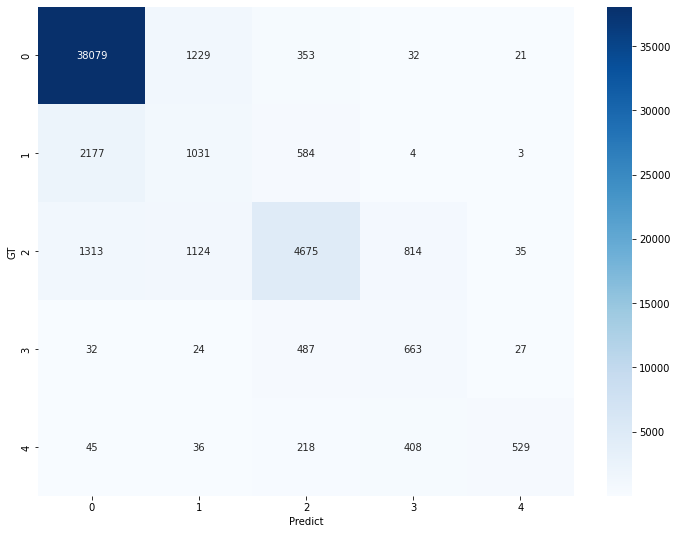

In [16]:
plt.figure(figsize=(12, 9))
sns.heatmap(cm_matrix, annot=True,fmt='g', cmap='Blues');
plt.xlabel("Predict");
plt.ylabel("GT");

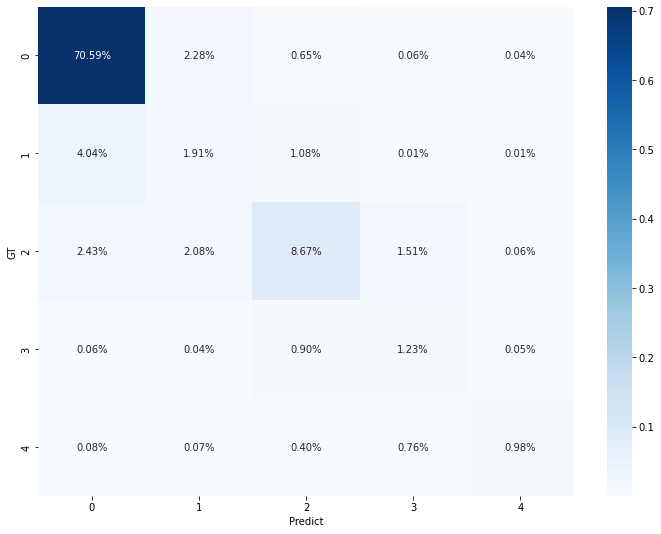

In [19]:
plt.figure(figsize=(12, 9))
sns.heatmap(cm_matrix/np.sum(cm_matrix), annot=True, fmt='.2%', cmap='Blues');
plt.xlabel("Predict");
plt.ylabel("GT");
plt.savefig('confusion_matrix.png');

<Figure size 432x288 with 0 Axes>

## 2. F1-score, Precision, Accuracy

In [39]:
recall_score(gt, clasif_pred, average='macro')

0.5318217869132857

In [40]:
recall_score(gt, clasif_pred, average='micro')

0.8397938564781343

In [41]:
recall_score(gt, clasif_pred, average='weighted')

0.8397938564781343

In [42]:
recall_score(gt, clasif_pred, average=None)

array([0.96656091, 0.27981048, 0.6107273 , 0.42822384, 0.37378641])

In [43]:
print(classification_report(gt, clasif_pred));

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     39714
           1       0.32      0.28      0.30      3799
           2       0.74      0.61      0.67      7961
           3       0.37      0.43      0.39      1233
           4       0.89      0.37      0.53      1236

    accuracy                           0.84     53943
   macro avg       0.65      0.53      0.57     53943
weighted avg       0.83      0.84      0.83     53943



## 3. Quadratic Weighted Kappa

In [44]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

In [45]:
qwk = quadratic_weighted_kappa(gt, clasif_pred)

In [46]:
print(qwk)

0.8229669168173392
